# Excercise 1: Autoencoder

We have allready seen a simple MLP model for **MNIST** classification:

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Get the data as Numpy arrays
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Build a simple model
inputs = keras.Input(shape=(28, 28))
l1 = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
l2 = layers.Flatten()(l1)
l3 = layers.Dense(128, activation="tanh")(l2)
l4 = layers.Dense(128, activation="tanh")(l3)
outputs = layers.Dense(10, activation="softmax")(l4)
model = keras.Model(inputs, outputs)
model.summary()

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

# Train the model for 1 epoch from Numpy data
batch_size = 64
print("Fit on NumPy data")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1)

# Train the model for 1 epoch using a dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
print("Fit on Dataset")
history = model.fit(dataset, epochs=1)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_______________________________________________________

Now we want to change this model and build an **autoencoder** for **MNIST**:

**1. change the network topology:** 
* use 5 dense layers to form "bottleneck" network (see lecture). 
* Layers 1+2 should be the encoder, 3 the lattent layer aner 4+5 the decoder
* remove the softmax (we are not doing a classification anymore)

**2. change the loss-function to compare input and output -> choose a suitable loss from https://keras.io/api/losses/**

**3. train the model**

**4. test the model**
* visualize input and output images to inspect the reconstruction quallity (use MATPLOTLIB *imshow*)
* implement a function to measure the reconstrunction error between in- and output
* change network size (number of neurons per layer) and training paramters to optimize the ressults 

**5. Outlier detection**
* plot a histogram over the the recostruction errors
* find a cutoff value and visualize the outliers

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

inputs = keras.Input(shape=(784,))
l1 = layers.Dense(64, activation="relu")(inputs)
l2 = layers.Dense(32, activation="relu")(l1)

l4 = layers.Dense(32, activation="relu")(l2)
l5 = layers.Dense(64, activation="relu")(l3)
outputs = layers.Dense(784, activation="sigmoid")(l4)

autoencoder = keras.Model(inputs, outputs)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_30 (Dense)             (None, 784)               25872     
Total params: 79,248
Trainable params: 79,248
Non-trainable params: 0
_________________________________________________________________


In [16]:
#2

loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

autoencoder.compile(loss=loss_fn, optimizer=optimizer)

In [31]:
#3
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

history = autoencoder.fit(x_train, x_train, batch_size=64, epochs=10,validation_data=[x_test, x_test] )

Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 1.8292e-06 - val_loss: 0.0000e+00
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 1.9558e-07 - val_loss: 0.0000e+00
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 1.6478e-07 - val_loss: 0.0000e+00
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 1.5467e-07 - val_loss: 0.0000e+00
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 1.5091e-07 - val_loss: 0.0000e+00
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 1.4952e-07 - val_loss: 0.0000e+00
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 1.4901e-07 - val_loss: 0.0000e+00
Epoch 8/10
938/938 [==============================] - 4s 4ms/step - loss: 1.4878e-07 - val_loss: 0.0000e+00
Epoch 9/10
938/938 [==============================] - 4s 4ms/step - loss: 1.4866e-07 - val_loss: 0.0000e+00
Epoch 10/10
938/938 [=======

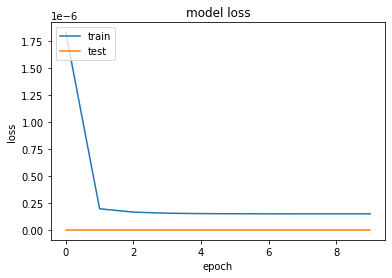

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
#4

# reference -> https://blog.keras.io/building-autoencoders-in-keras.html

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

def show_imgs(imgs):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

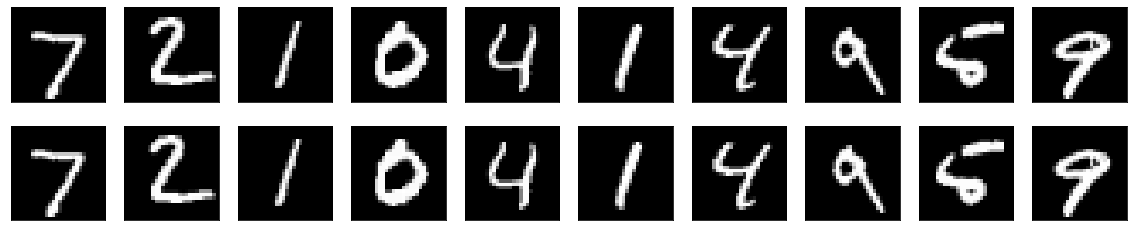

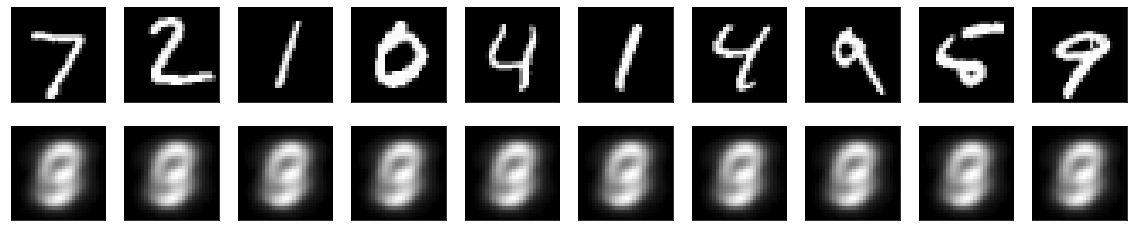

In [33]:
test = autoencoder.predict(x_train)
show_imgs(x_test)
show_imgs(test)